In [ ]:
%load_ext autoreload
%autoreload 2
import logging
logging.basicConfig(level=logging.INFO)
import matplotlib.pyplot as plt

import geopandas as gpd
from eodag import EODataAccessGateway
import rioxarray as riox
import numpy as np

# credentials need to be stored in the following file (see EODAG docs)
confpath = "/data/eodag_config.yml"
dag = EODataAccessGateway(user_conf_file_path=confpath)
# make sure cop_dataspace will be used 
dag.set_preferred_provider("cop_dataspace")
log = logging.getLogger(__name__)

## Set up parameters and output dir

### Important
- The products must be **unzipped** either manually or by using `extract=True` in the download call. 
- In the following products, only IW1 and IW2 are relevant as IW3 contains only water pixels.

In [2]:
# change to your custom locations
data_dir = "/data/S1"

ids = [
 "S1A_IW_SLC__1SDV_20230904T063730_20230904T063757_050174_0609E3_DAA1", 
 "S1A_IW_SLC__1SDV_20230916T063730_20230916T063757_050349_060FCD_6814"
]
primary_dir = f"{data_dir}/{ids[0]}.SAFE"
secondary_dir = f"{data_dir}/{ids[1]}.SAFE"
outputs_prefix="/data/res/test-change-detection-pipeline"

## Download S-1 products

In [ ]:
# load a geometry
file_aoi = "../data/Morocco_AOI.geojson"
shp = gpd.read_file(file_aoi).geometry[0]

search_criteria = {
    "productType": "S1_SAR_SLC",
    "start": "2023-09-03",
    "end": "2023-09-17",
    "geom": shp
}

results, _ = dag.search(**search_criteria)
to_dl = [it for it in results if it.properties["id"] in ids]
print(f"{len(to_dl)} products to download")
# dag.download_all(to_dl, outputs_prefix="/data/S1/", extract=False)

## Pre-process InSAR pair

In [ ]:
from eo_tools.S1.process import prepare_insar

out_dir = prepare_insar(
    dir_prm=primary_dir,
    dir_sec=secondary_dir,
    outputs_prefix=outputs_prefix,
    aoi_name=None,
    shp=shp,
    pol="full",
    subswaths=["IW1", "IW2", "IW3"],
    cal_type="sigma",
    apply_fast_esd=False,
    dem_upsampling=1.8,
    dem_force_download=True,
    dem_buffer_arc_sec=40,
    warp_kernel="bicubic",
)

## Define a simple amplitude change detection function

In [7]:
def change_detection(file_amp_prm, file_amp_sec, file_out):
    log.info("Smoothing amplitudes")
    amp_prm = riox.open_rasterio(file_amp_prm)[0].rolling(x=7, y=7, center=True).mean()
    amp_sec = riox.open_rasterio(file_amp_sec)[0].rolling(x=7, y=7, center=True).mean()
    log.info("Incoherent changes")
    ch = np.log(amp_prm+1e-10) - np.log(amp_sec+1e-10)
    ch.rio.to_raster(file_out)

## Apply processing chains: coherence and change detection

In [ ]:
from eo_tools.S1.process import coherence, amplitude
from eo_tools.S1.process import apply_to_patterns_for_pair, apply_to_patterns_for_single
from pathlib import Path

out_dir = f"{outputs_prefix}/S1_InSAR_2023-09-04-063730__2023-09-16-063730/sar"
geo_dir = Path(out_dir).parent

# compute interferometric coherence
apply_to_patterns_for_pair(
    coherence,
    out_dir=out_dir,
    file_prm_prefix="slc_prm",
    file_sec_prefix="slc_sec",
    file_out_prefix="coh",
    box_size=[3, 10],
    multilook=[1, 4],
)

# compute primary amplitude
apply_to_patterns_for_single(
    amplitude,
    out_dir=out_dir,
    file_in_prefix="slc_prm",
    file_out_prefix="amp_prm",
    multilook=[2, 8],
)

# compute secondary amplitude
apply_to_patterns_for_single(
    amplitude,
    out_dir=out_dir,
    file_in_prefix="slc_sec",
    file_out_prefix="amp_sec",
    multilook=[2, 8],
)

# compute incoherent changes
apply_to_patterns_for_pair(
    change_detection,
    out_dir=out_dir,
    file_prm_prefix="amp_prm",
    file_sec_prefix="amp_sec",
    file_out_prefix="change",
)

## Apply geocoding, merge and crop subswaths

In [ ]:
from eo_tools.S1.process import geocode_and_merge_iw
geo_dir = Path(out_dir).parent
geocode_and_merge_iw(geo_dir, shp=shp, var_names=["coh","change"])

## Visualize

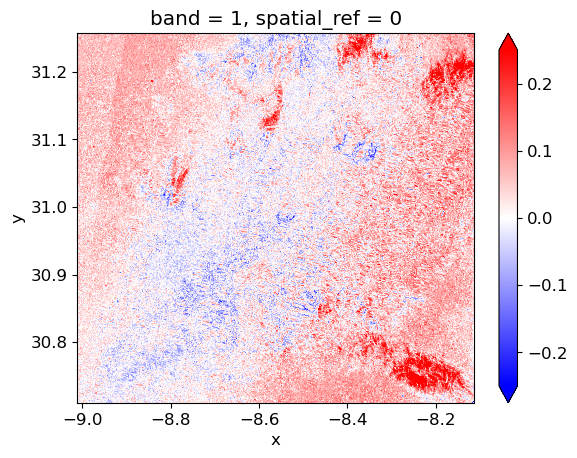

In [19]:
arr_amp = riox.open_rasterio(f"{geo_dir}/change_vv.tif", masked=True)[0]
arr_amp.plot.imshow(vmin=-0.25, vmax=0.25, cmap="bwr")

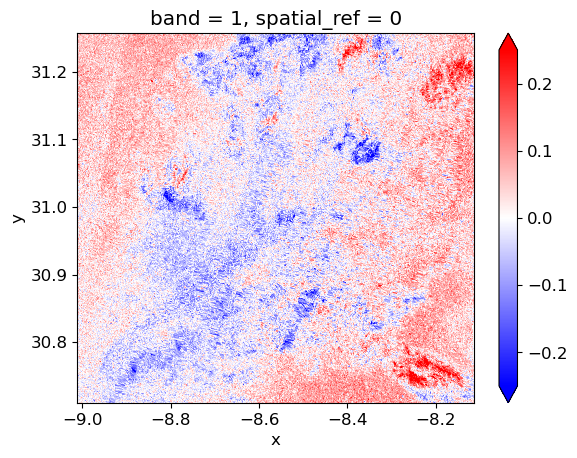

In [20]:
arr_amp = riox.open_rasterio(f"{geo_dir}/change_vh.tif", masked=True)[0]
arr_amp.plot.imshow(vmin=-0.25, vmax=0.25, cmap="bwr")

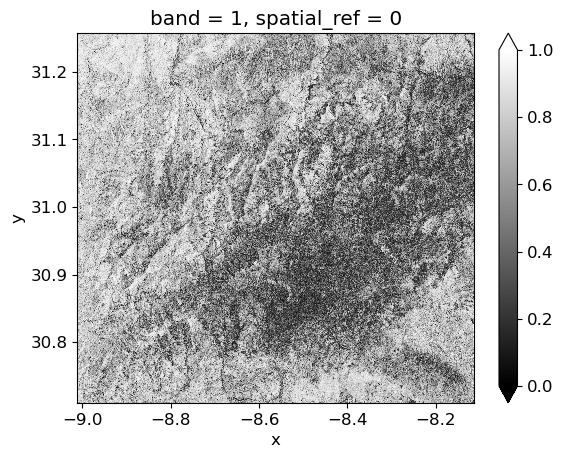

In [21]:
arr_coh = riox.open_rasterio(f"{geo_dir}/coh_vv.tif", masked=True)[0]
arr_coh.plot.imshow(vmin=0,vmax=1, cmap="gray")

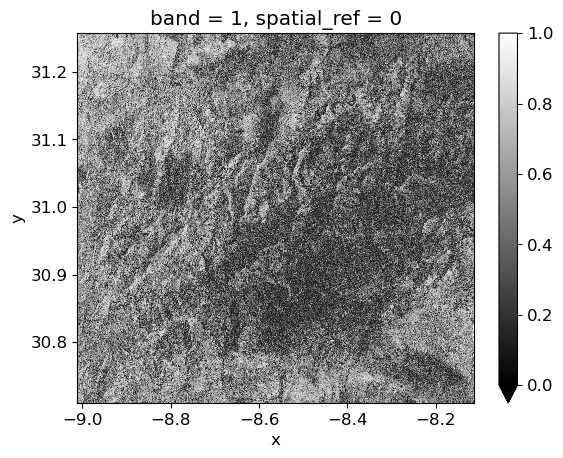

In [22]:
arr_coh = riox.open_rasterio(f"{geo_dir}/coh_vh.tif", masked=True)[0]
arr_coh.plot.imshow(vmin=0,vmax=1, cmap="gray")